# 지성민님 코드 필사 및 스터디

github folder

# import

In [1]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
# from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format

# Evaluate Metric
- MAE(Mean Absolute Error) : 절대값 오차의 평균
- validation을 위한 함수 생성 및 make scorer

In [4]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

# ISSUE

1) 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음
 - 월 단위로 resampling 후 forecast 범위를 3개월로 지정해야 해결


2) 1967개의 store_id가 각각 trend와 seasonality를 가지고 있음
 - 같은 알고리즘에서 각 store_id별로 parameter를 조절
  

3) 예측 날짜는 2019-03~2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 존재
 - 마지막 날짜부터 3개월만 예측하여 제출한다.(ex:store_id 111의 마지막 날짜는 2018-09월로 뒤 3개월인 2018-10~2018~12만 예측하여 제출)
 - 예측 기간이 길어질수록 오차가 크게 발생해 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/140472_store_credit_card_revenue_data/funda_train.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/140472_store_credit_card_revenue_data/submission.csv')


In [6]:
df_train.head()


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [7]:
df_train.store_id.nunique()

1967

In [8]:
df_train.store_id.nunique()

1967

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [10]:
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   datetime64[ns]
 4   transacted_time   object        
 5   installment_term  int64         
 6   region            object        
 7   type_of_business  object        
 8   amount            float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 450.2+ MB


In [11]:
print(df_train.shape)

(6556613, 9)


In [12]:
df_train.columns

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')

In [13]:
frame_info = [(col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]) for col in df_train.columns]
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])

In [14]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


### 시계열 분석을 위해 data 정보를 index로 변환

In [15]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000


### 시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling
- 'store_id', 'region', 'type_of_business' 기존과 동일
- day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
- business_day : working day 여부, 1이면 working day 0이면 주말
- num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
- num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
- installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
- amount : 일 매출 액, 기존 amount의 합

In [16]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    for i in train_df.store_id.unique():
        df_num = train_df[train_df.store_id == i]

        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay') # 'card_id' 의 일별 counting을 통해 일 거래 횟수 확인
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values 
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')  
        sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum() # 할부 개월수와 매출액은 일 단위로 합

        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

        df_num_day.insert(0, 'store_id', i)
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])

        df_day = pd.concat([df_day, df_num_day], axis=0)
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    df_day.num_of_revisit.fillna(0, inplace=True)
    
    return df_day


In [17]:
%%time
df_day = resample_day(df_train)
df_day

CPU times: user 2min 5s, sys: 2.77 s, total: 2min 7s
Wall time: 1min 47s


,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143
...,...,...,...,...,...,...,...,...,...
2019-02-24,2136,6,0,13,1.00000,0,제주 제주시,기타 주점업,85357.14286
2019-02-25,2136,0,1,7,2.00000,0,제주 제주시,기타 주점업,37214.28571
2019-02-26,2136,1,1,6,1.00000,0,제주 제주시,기타 주점업,47142.85714


In [18]:
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [19]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


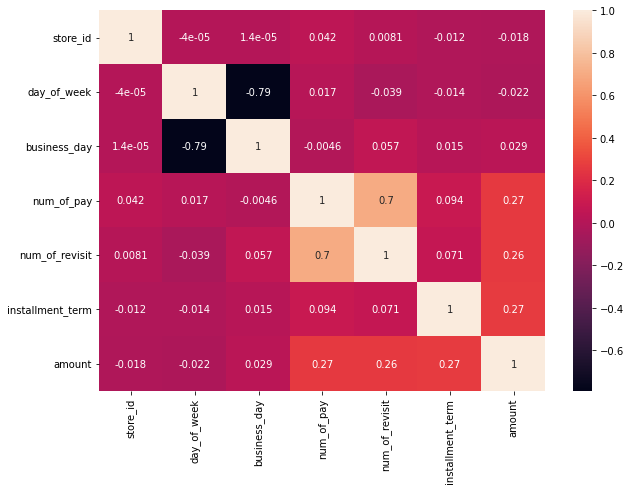

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True)

## Modeling을 위해 Month 단위로 resampling¶


In [21]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714


In [22]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [23]:
%%time
df_month = resample_month(df_day)

CPU times: user 1min 7s, sys: 1.13 s, total: 1min 8s
Wall time: 1min 4s


In [24]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [25]:
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [26]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [27]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143


# Step2. EDA

### 변수의 describe 확인

In [28]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06964,15.89620,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75343,5.63154,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


### target 변수의 대칭성(정규성) 확인

Skewness : 0.4824551090840111


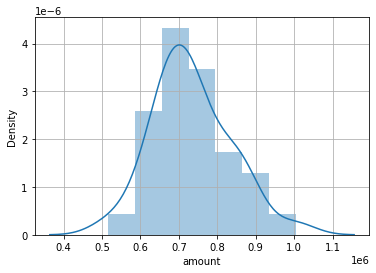

Skewness : 0.5102521050694763


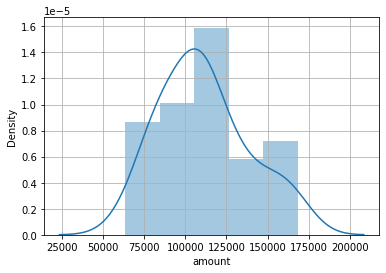

Skewness : 0.9982599271676992


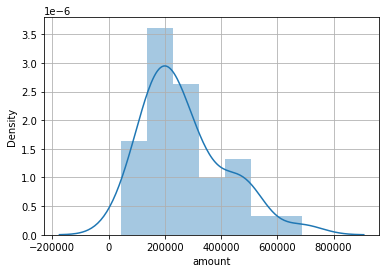

In [29]:
for i in df_month.store_id.unique()[:3]:
  print("Skewness :", df_month[df_month.store_id == i].amount.skew()) # 왜도함수 skew()
  sns.distplot(df_month[df_month.store_id == i].amount)
  plt.grid()
  plt.show()

-0.5308009496851175


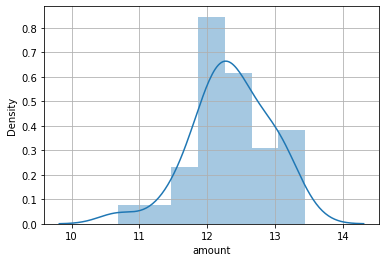

In [30]:
print(np.log(df_month[df_month.store_id == 2].amount).skew())
sns.distplot(np.log(df_month[df_month.store_id == 2].amount))
plt.grid()
plt.show()

## 각 변수의 value 분포 시각화

In [31]:
df_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143
...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.00000,338.00000,86.00000,0.00000,2012214.28571
2018-11-30,2136,28,20.00000,356.00000,87.00000,0.00000,2135428.57143
2018-12-31,2136,31,21.00000,403.00000,109.00000,0.00000,2427428.57143
2019-01-31,2136,31,23.00000,297.00000,74.00000,3.00000,1873642.85714


In [32]:
pd.melt(df_month, value_vars=df_month.columns[1:])

,variable,value
0,real_tot_day,25.00000
1,real_tot_day,26.00000
2,real_tot_day,24.00000
3,real_tot_day,25.00000
4,real_tot_day,26.00000
...,...,...
365485,amount,2012214.28571
365486,amount,2135428.57143
365487,amount,2427428.57143
365488,amount,1873642.85714


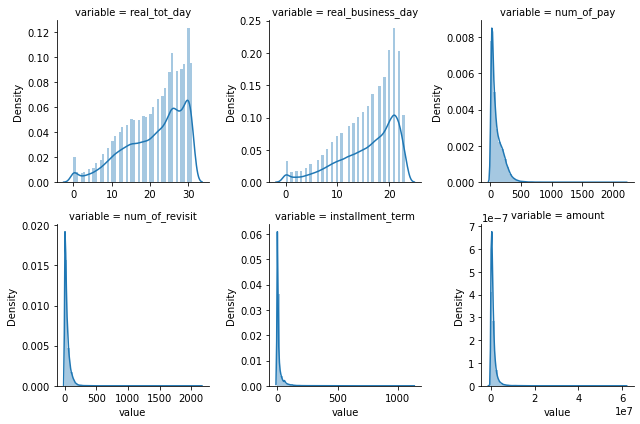

In [33]:
f = pd.melt(df_month, value_vars=df_month.columns[1:])  # 컬럼을 녹여서 행으로 보냄
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.show()

## 같은기간 동안 여러 상점 매출의 추이 및 스케일 확인(0~7)
- 각 store_id 별로 다른 trend와 seasonality, scale을 가지는 것을 확인할 수 있음

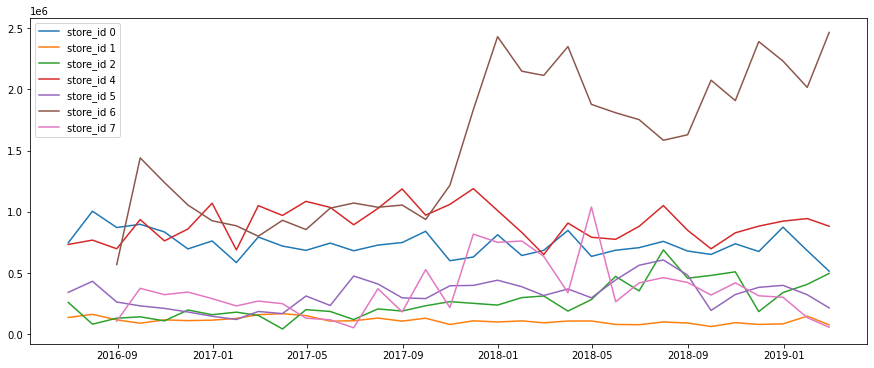

In [34]:
plt.figure(figsize=(15,6))
for i in df_month.store_id.unique()[:7]:
  plt.plot(df_month[df_month.store_id == i].index, df_month[df_month.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

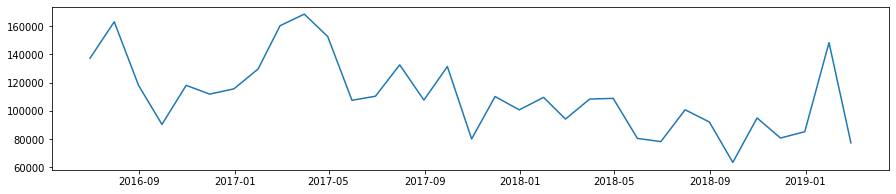

In [35]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 1].index, df_month[df_month.store_id == 1].amount)

## 다른 변수들이 'amount'와 같은 pattern을 가지는지 확인

In [36]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

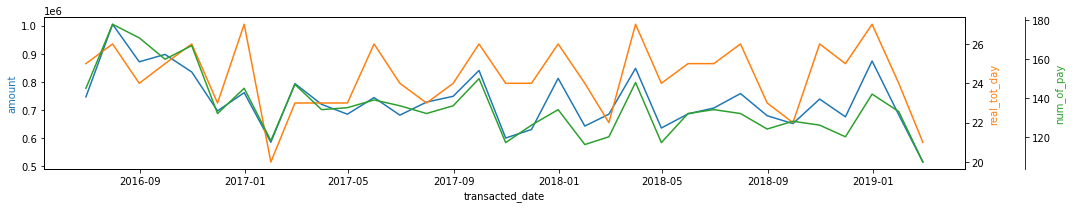

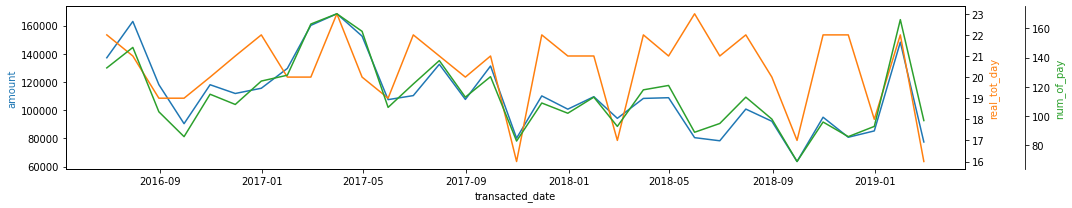

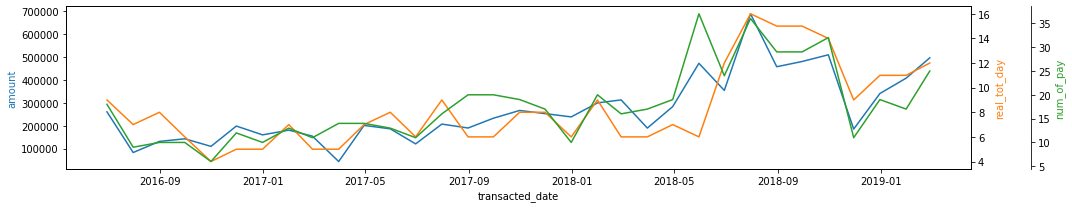

In [37]:
for i in df_month.store_id.unique()[:3]:
    plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

# Step3. Modeling - Time Series
Simple Moving Average
- 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
- 이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
- 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.

In [40]:
def make_sma_arr(window_num):
  ma_arr = np.array([])
  for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values)) # concatenate: 축방향으로 배열 연결

  return ma_arr

In [41]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

In [43]:
sma_month.head(7)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,NaN,NaN,NaN
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,876000.00000,NaN,NaN
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,938285.71429,874523.80952,NaN
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,884714.28571,924809.52381,NaN
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,866642.85714,868285.71429,NaN
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,697000.00000,766214.28571,810095.23810,842309.52381
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,761857.14286,729428.57143,764761.90476,844785.71429


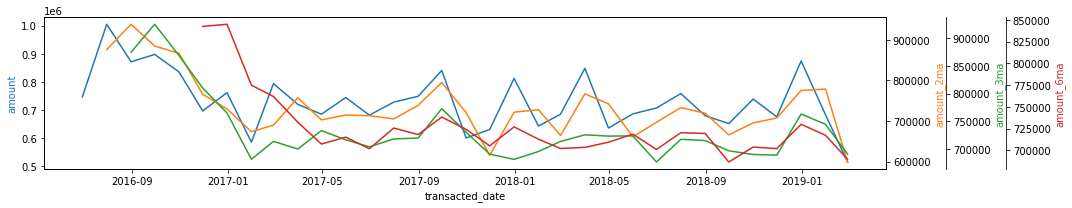

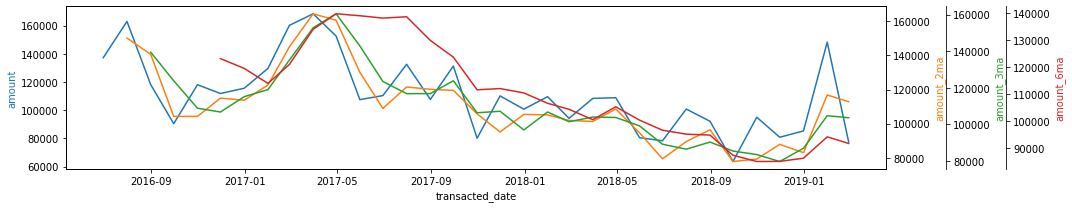

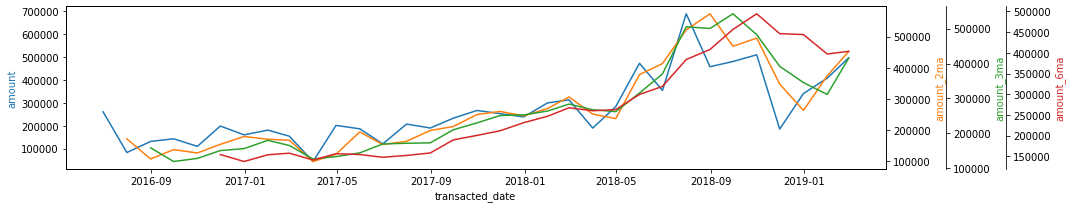

In [44]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [45]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.4552831229
6 window SMA MAE Score :  387465.0993765708


2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708

- rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
-우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

In [46]:
def make_minus_rolling(data_frame, rolling_num):
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:])
        b = np.average(np.append(df_set.values[-(num-1):], a))
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
        
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [48]:
for i in range(2, 5):
    df_rolling = make_minus_rolling(df_month, i)
    df_rolling.to_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/sub/funda_{}_rolling_sub.csv'.format(i), index=False)

## Exponential Moving Average¶
- 지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.

In [49]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [50]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

In [51]:
ewm_month.head(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,747000.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,919000.00000,897500.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,891897.95918,885844.03670


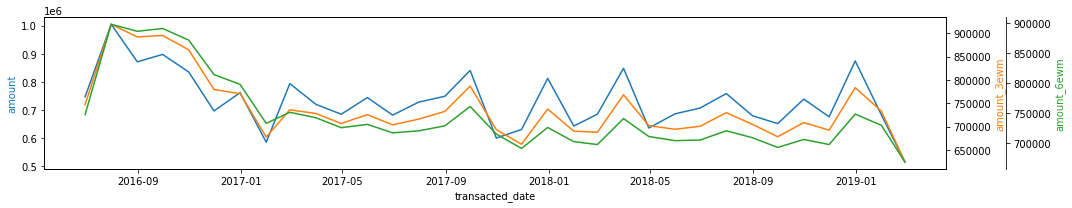

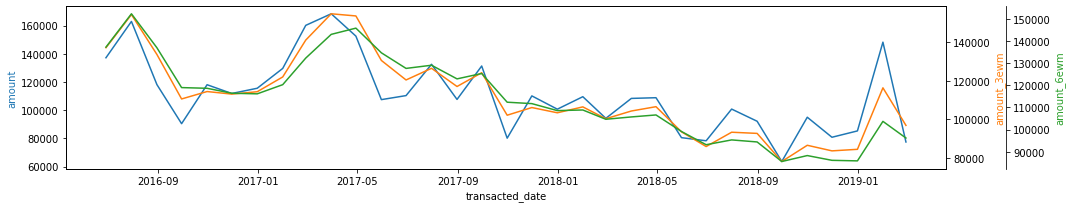

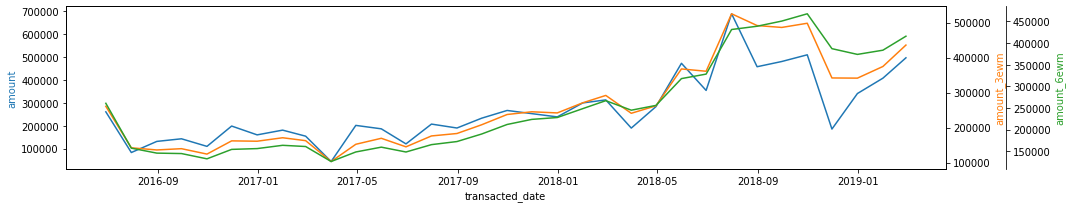

In [52]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [53]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


In [54]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    
    return df_wma_sub

In [55]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    wma_sub.to_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/sub/funda_{}wma_sub.csv'.format(i), index=False)